# Introduction Forecasting with State Space Models (Unobserved Components)

In this notebook we will provide a very short introduction into a family of state space models for time series forecasting: [*Univariate unobserved components time series model*](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html). We will use the implementation available in [statsmodels](https://www.statsmodels.org/stable/index.html). Please refer do the (great!) documentation to get more details on the model structure and assumptions. 

---

# Part I: Introduction + Model Structure

Let us take some main aspects from the [Time Series Analysis by State Space Methods `statespace` User Guide](https://www.statsmodels.org/stable/statespace.html):

## State Space Model Structure

Let us consider the general form of state space models:

<center>
  <figure>
    <img src="images/statsmodels_docs_images/ssm_structure.png" style="width: 800px;"/>
    <figcaption> Taken https://www.statsmodels.org/stable/statespace.html </figcaption>
  </figure>
</center>

## Example: AR(2) Model

Auto-regressive model can be written as space state models. For example for an $AR(2)$ process we have:

<center>
  <figure>
    <img src="images/statsmodels_docs_images/ssm_ar.png" style="width: 800px;"/>
    <figcaption> Taken https://www.statsmodels.org/stable/statespace.html </figcaption>
  </figure>
</center>

## Example: Exponential Smoothing

Exponential smoothing models can also be written as state space models, see [Forecasting Principles: Principles and Practice, Innovations state space models for exponential smoothing](https://otexts.com/fpp3/ets.html).

<center>
  <figure>
    <img src="images/statsmodels_docs_images/ssm_es.png" style="width: 800px;"/>
    <figcaption> Taken from https://otexts.com/fpp3/ets.html </figcaption>
  </figure>
</center>

## Unobserved Componets Model

Next we deep-dive into the unobserved components state space model. 

<center>
  <figure>
    <img src="images/statsmodels_docs_images/uc_intro.png" style="width: 800px;"/>
    <figcaption> Taken from https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html </figcaption>
  </figure>
</center>

The most general structure has the form:

<center>
  <figure>
    <img src="images/statsmodels_docs_images/uc_structure.png" alt="glue" style="width: 500px;"/>
    <figcaption> Taken from https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html </figcaption>
  </figure>
</center>

Now let us explore each of the components:

### Trend:

Here is the model for the trend component:

$$
\begin{align*}
y_t &= \mu_t + \varepsilon_t \quad \text{(observed time series)}\\
\mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_{t-1} \quad \text{(level component)}\\
\beta_t &= \beta_{t-1} + \zeta_{t-1} \quad \text{(trend component)}
\end{align*}
$$

There are many model flavours, e.g.

<center>
  <figure>
    <img src="images/statsmodels_docs_images/uc_types.png" style="width: 500px;"/>
    <figcaption> Taken from https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html </figcaption>
  </figure>
</center>

### Seasonality

<center>
  <figure>
    <img src="images/statsmodels_docs_images/uc_seasonal.png" style="width: 800px;"/>
    <figcaption> Taken from https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html </figcaption>
  </figure>
</center>

### Other Components

<center>
  <figure>
    <img src="images/statsmodels_docs_images/uc_other.png" alt="glue" style="width: 800px;"/>
    <figcaption> Taken from https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html </figcaption>
  </figure>
</center>


## References:

- [Statsmodels documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
- [Time Series Analysis by State Space Methods](https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780199641178.001.0001/acprof-9780199641178), Durbin, James, and Siem Jan Koopman.
- [Time Series Analysis and Its Applications - Chapter 6: Space Space Models](https://www.stat.pitt.edu/stoffer/tsa4/Chapter6.pdf)
- [Forecasting with the Kalman Filter (PyData Chicago 2016)](https://www.youtube.com/watch?v=GmSXhmbv5Zg), by Mike Mull
- [Modern Time Series Analysis (SciPy 2019 Tutorial)](https://www.youtube.com/watch?v=v5ijNXvlC5A&t=10813s), by Aileen Nielsen

---

# Part II. Simulated Example

We now work out a concrete example with simulated data to have a btetter control on the model assesment.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from statsmodels.tsa.statespace.structural import UnobservedComponents

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%reload_ext autoreload
%autoreload 2

## Generate Sample Data

Let us generate some time series data. First, we define the time range:

In [2]:
min_date = pd.to_datetime('2017-01-01')
max_date = pd.to_datetime('2022-01-01')

data_df = pd.DataFrame(
    data={'date': pd.date_range(start=min_date, end=max_date, freq='M')}
)

n = data_df.shape[0]

Next, we generate the trend component. To do so, we use a parameter mapping to control the type of model to sample from.

In [3]:
def generate_data(n, params, sigma_zeta=0.1, sigma_eta=0.1, sigma_epsilon=0.1):
    # Initialize variables
    y = np.zeros(n)
    mu = np.zeros(n)
    beta = np.zeros(n)
    epsilon = np.zeros(n)
    eta = np.zeros(n)
    zeta = np.zeros(n)

    # Sample from model parameters.
    for t in range(1, n):
        
        zeta[t] = params['zeta'] * np.random.normal(loc=0.0, scale=sigma_zeta)
        beta[t] = params['beta_1'] * beta[t - 1] + zeta[t]
        
        eta[t] = params['eta'] * np.random.normal(loc=0.0, scale=sigma_eta)
        mu[t] = params['mu_1'] * mu[t -1] + params['beta_1'] * beta[t - 1] + eta[t]

        epsilon[t] = params['epsilon'] * np.random.normal(loc=0.0, scale=sigma_epsilon)
        y[t] = params['mu'] * mu[t] + epsilon[t]

    return y, mu, beta

In [4]:
from mapping import PARAMS

np.random.seed(1)

model_names = list(PARAMS.keys())

model_name = model_names[2]
params = PARAMS.get(model_name, 'irregular')

y, mu, beta = generate_data(n=n, params=params)

print(params)

{'zeta': 0, 'beta': 0, 'beta_1': 0, 'eta': 1, 'epsilon': 1, 'mu_1': 1, 'mu': 1}


Let us plot the trend components:

In [5]:
fig = plt.figure(figsize=(12, 7), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[:, 0])
sns.lineplot(x=data_df['date'], y=y, marker='o', markersize=5, color=sns_c[0], label=r'$y_t$', ax=ax)
sns.lineplot(x=data_df['date'], y=mu, marker='o', markersize=5, color=sns_c[1], label=r'$\mu_t$', ax=ax)
sns.lineplot(x=data_df['date'], y=beta, marker='o', markersize=5, color=sns_c[2], label=r'$\beta_t$', ax=ax)

ax0 = fig.add_subplot(gs[0, 1])
sns.lineplot(x=data_df['date'], y=mu, marker='o', markersize=5, color=sns_c[1], label=r'$\mu_t$', ax=ax0)

ax1 = fig.add_subplot(gs[1, 1])
sns.lineplot(x=data_df['date'], y=beta, marker='o', markersize=5, color=sns_c[2], label=r'$\beta_t$', ax=ax1)

fig.suptitle(f'Simulation Data - {model_name}\n{params}');

SyntaxError: invalid syntax (122312289.py, line 13)

Let us generate a target variable `z` to model by adding an external regressor `x` and a seasonal component `s`.

In [ ]:
data_df['y'] = y

# Add external regressor.
x = np.random.uniform(low=0.0, high=1.0, size=n)
data_df['x'] = np.where( x > 0.80, x, 0)
# Add seasonal component.
data_df['cs'] = np.sin(2 * np.pi * data_df['date'].dt.dayofyear / 356.5) 
data_df['cc'] = np.cos(3 * np.pi * data_df['date'].dt.dayofyear / 356.5) 
data_df['s'] = data_df['cs'] + data_df['cc']
# Construct target variable.
data_df['z'] = data_df['y'] + data_df['x'] + data_df['s']

Let us plot the resulting target variable and its components:

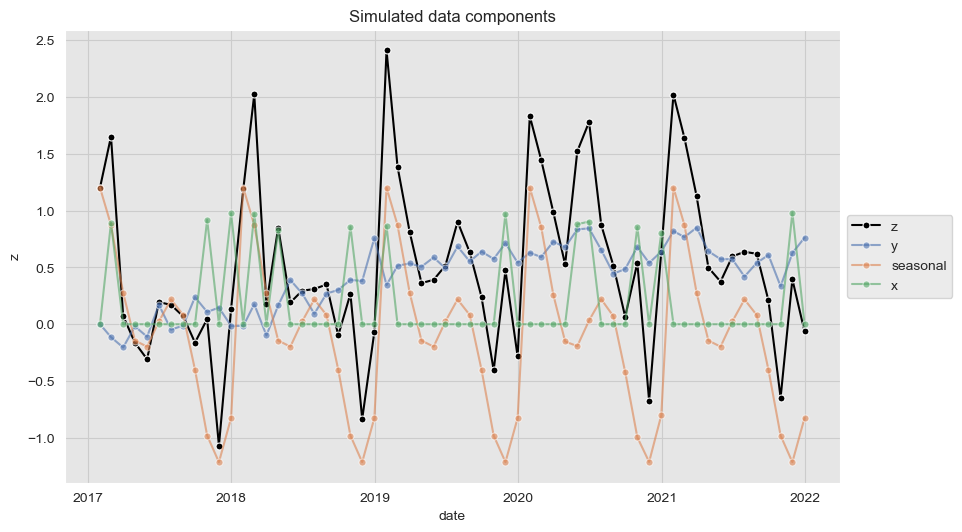

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='z', data=data_df, marker='o', markersize=5, color='black', label='z', ax=ax)
sns.lineplot(x='date', y='y', data=data_df, marker='o', markersize=5, color=sns_c[0], alpha=0.6, label='y', ax=ax)
sns.lineplot(x='date', y='s', data=data_df, marker='o', markersize=5, color=sns_c[1], alpha=0.6, label='seasonal', ax=ax)
sns.lineplot(x='date', y='x', data=data_df, marker='o', markersize=5, color=sns_c[2], alpha=0.6, label='x', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Simulated data components');

In [ ]:
# Set date as index.
data_df.set_index('date', inplace=True)
data_df.index = pd.DatetimeIndex(
    data=data_df.index.values,
    freq=data_df.index.inferred_freq
)

We not do a train-test split of the data:

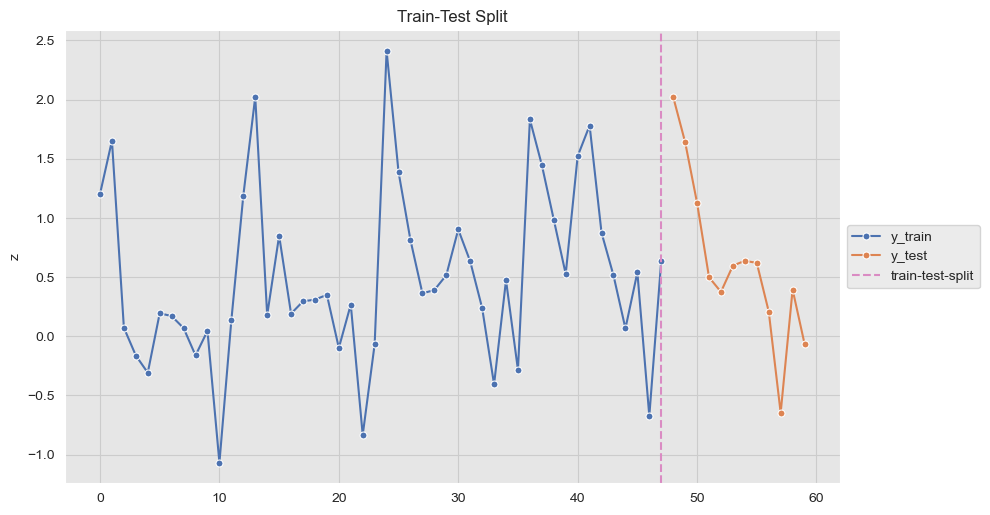

In [ ]:
train_test_ratio = 0.80
n_train = int(n * train_test_ratio)
n_test = n - n_train

data_train_df = data_df[: n_train]
data_test_df = data_df[- n_test :]

y_train = data_train_df['z']
x_train = data_train_df[['x']]

y_test = data_test_df['z']
x_test = data_test_df[['x']]

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, marker='o', markersize=5, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, marker='o', markersize=5, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.tail(1).index[0], color=sns_c[6], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Train-Test Split');

## Model

Now that we have the data, let us use the `statsmodels` implementation of the unobserved components model to generate forecasts on the test-set.

In [ ]:
model_params =  {
    'endog': y_train,
    'exog': x_train,
    'level': 'local level',
    'freq_seasonal': [
         {'period': 12, 'harmonics': 4}
    ],
    'autoregressive': 1,
    'mle_regression': False,
 }
 
model = UnobservedComponents(**model_params)

result = model.fit()

result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88032D+00    |proj g|=  9.56529D-01

At iterate    5    f=  1.08137D-01    |proj g|=  6.21681D-01

At iterate   10    f=  7.79757D-02    |proj g|=  5.15235D-01

At iterate   15    f=  7.15159D-02    |proj g|=  1.43524D-02

At iterate   20    f=  7.15129D-02    |proj g|=  7.36950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   7.370D-05   7.151D-02
  F =   7.1512904488937920E-002

CONVERG

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     z   No. Observations:                   48
Model:                                   local level   Log Likelihood                  -3.433
                   + stochastic freq_seasonal(12(4))   AIC                             16.865
                                             + AR(1)   BIC                             25.053
Date:                               Wed, 18 Aug 2021   HQIC                            19.778
Time:                                       13:28:18                                         
Sample:                                   01-31-2017                                         
                                        - 12-31-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0290      0.037      0.786      0.432      -0.043       0.101
sigma2.level                   0.0035      0.004      0.920      0.358      -0.004       0.011
sigma2.freq_seasonal_12(4)  2.443e-11      0.000   6.79e-08      1.000      -0.001       0.001
sigma2.ar                   2.941e-13      0.056   5.22e-12      1.000      -0.110       0.110
ar.L1                          0.2269   1.17e-13   1.94e+12      0.000       0.227       0.227
===================================================================================
Ljung-Box (L1) (Q):                   5.51   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.02   Prob(JB):                         0.75
Heteroskedasticity (H):               1.63   Skew:                             0.01
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+39. Standard errors may be unstable.
"""

Let us plot the components of the model:

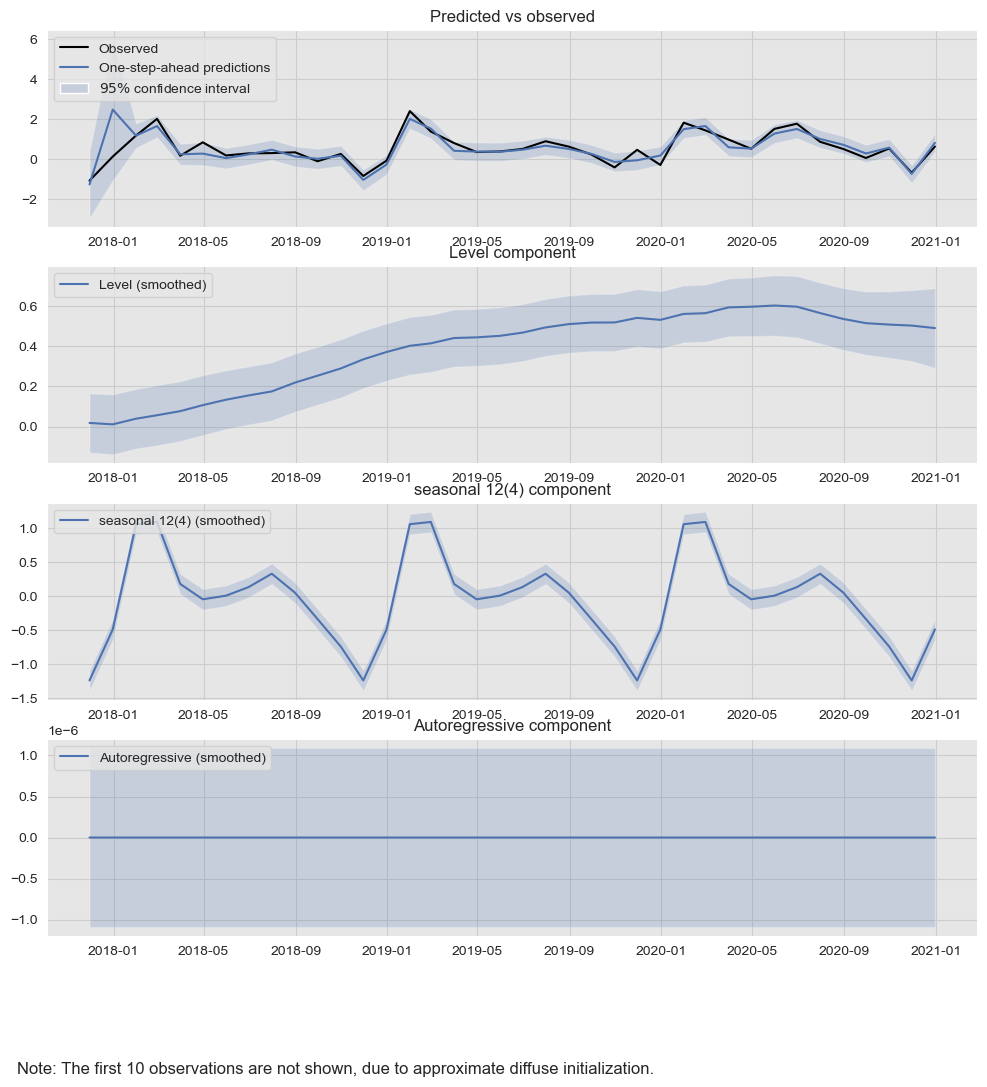

In [ ]:
result.plot_components(
    alpha=0.05,
    legend_loc='upper left',
    figsize=(12, 12)
);

## Predictions

We can now generate predictions on the training and test sets (with prediction intervals)

In [ ]:
predictions_df = result \
    .get_prediction(steps=n_train, exog=x_train) \
    .summary_frame(alpha=0.95)

forecast_df = result \
    .get_forecast(steps=n_test, exog=x_test) \
    .summary_frame(alpha=0.95)

predictions_df.iloc[0] = 0

In addition, we can simulate from the fitted model:

In [ ]:
repetitions = 100

simulations_train_df = result.simulate(
    anchor='start',
    nsimulations=n_train,
    repetitions=repetitions,
    exog=x_train
)

simulations_test_df = result.simulate(
    anchor='end',
    nsimulations=n_test,
    repetitions=repetitions,
    exog=x_test
)

We can compute some statistics from the simulated samples:

In [ ]:
y_train_pred_mean = simulations_train_df.mean(axis=1)
y_train_pred_std = simulations_train_df.std(axis=1)
y_train_pred_plus = y_train_pred_mean + 2 * y_train_pred_std
y_train_pred_minus = y_train_pred_mean - 2 * y_train_pred_std

y_test_pred_mean = simulations_test_df.mean(axis=1)
y_test_pred_std = simulations_test_df.std(axis=1)
y_test_pred_plus = y_test_pred_mean + 2 * y_test_pred_std
y_test_pred_minus = y_test_pred_mean - 2 * y_test_pred_std

Finally, let us visualize the results:

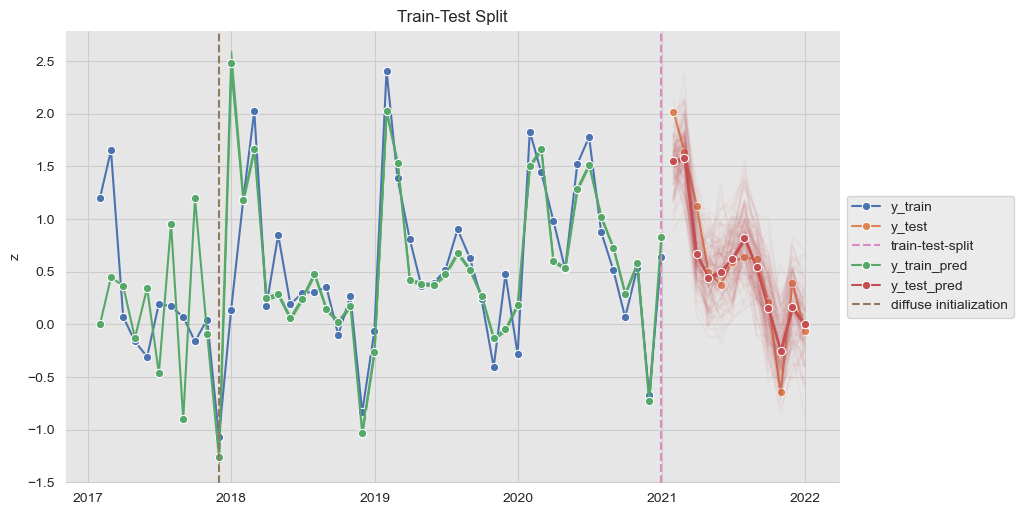

In [ ]:
fig, ax = plt.subplots()

# Input data
sns.lineplot(
    x=y_train.index,
    y=y_train,
    marker='o',
    markersize=5,
    color=sns_c[0],
    label='y_train',
    ax=ax
)
sns.lineplot(
    x=y_test.index,
    y=y_test,
    marker='o',
    markersize=5,
    color=sns_c[1],
    label='y_test',
    ax=ax
)
ax.axvline(
    x=x_train.tail(1).index[0],
    color=sns_c[6],
    linestyle='--',
    label='train-test-split'
)

# Simulations
for col in simulations_test_df.columns:
    sns.lineplot(
        x=simulations_test_df.index,
        y=simulations_test_df[col],
        color=sns_c[3],
        alpha=0.05, 
        ax=ax
    )

# Prrediction intervals
ax.fill_between(
    x=y_train.index[10: ],
    y1=predictions_df['mean_ci_lower'][10: ],
    y2=predictions_df['mean_ci_upper'][10: ],
    color=sns_c[2],
    alpha=0.8
)
ax.fill_between(
    x=y_test.index,
    y1=forecast_df['mean_ci_lower'],
    y2=forecast_df['mean_ci_upper'],
    color=sns_c[3],
    alpha=0.8
)

# Predictions
sns.lineplot(
    x=y_train.index,
    y=predictions_df['mean'],
    marker='o',
    markersize=5,
    color=sns_c[2],
    label='y_train_pred',
    ax=ax
)
sns.lineplot(
    x=y_test.index,
    y=forecast_df['mean'],
    marker='o',
    markersize=5,
    color=sns_c[3],
    label='y_test_pred',
    ax=ax
)
ax.axvline(
    x=y_train.index[10],
    color=sns_c[5],
    linestyle='--',
    label='diffuse initialization'
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Train-Test Split');